In [1]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import objectives
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, core
from keras.utils.layer_utils import print_summary
from keras.utils import np_utils
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import timeit
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import RandomForest
from sklearn.cross_validation import cross_val_score
from scipy.misc import imresize
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn import cross_validation
from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import StratifiedKFold
import numpy
import random
import h5py
%matplotlib inline

from keras.backend import image_dim_ordering, set_image_dim_ordering

# Image dimensions ordering should follow the Theano convention
if image_dim_ordering() != 'th':
    set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
#Load the data
h5f = h5py.File('data32.h5','r')
all_input_3D = h5f['dataset_1'][:]
h5f.close()

#Testing the results with one-patient-leave-one

In [3]:
#Create the labels
label_0=np.concatenate((np.zeros(1408),np.ones(1408),np.zeros(256),np.ones(256),np.zeros(384),np.ones(384)))
ind=np.concatenate((np.zeros(11),np.ones(11),np.zeros(2),np.ones(2),np.zeros(3),np.ones(3)))

#Training VGG16 loading weights

In [3]:
# Definiton of the OCT-model with input of 3 x 224 x 224

classes=2
input = Input(shape=(3,224,224))
conv1 = Convolution2D(32, 3, 3, activation='relu')(input)
conv2 = Convolution2D(32, 3, 3, activation='relu')(conv1)
conv3 = Convolution2D(32, 3, 3, activation='relu')(conv2)
pool1 = MaxPooling2D((2,2), strides=(2,2))(conv3)
#
conv4 = Convolution2D(64, 3, 3, activation='relu')(pool1)
conv5 = Convolution2D(64, 3, 3, activation='relu')(conv4)
pool2 = MaxPooling2D((2,2), strides=(2,2))(conv5)
#
conv6 = Convolution2D(128, 3, 3, activation='relu')(pool2)
conv7 = Convolution2D(128, 3, 3, activation='relu')(conv6)
pool3 = MaxPooling2D((2,2), strides=(2,2))(conv7)
#
conv8 = Convolution2D(256, 3, 3, activation='relu')(pool3)
conv9 = Convolution2D(256, 3, 3, activation='relu')(conv8)
conv10 = Convolution2D(256, 3, 3, activation='relu')(conv9)
pool4 = MaxPooling2D((2,2), strides=(2,2))(conv10)
#
flatten = Flatten()(pool4)
dense1 = Dense(4096, activation='relu')(flatten)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1000, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(2, activation='softmax')(drop2)
model1 = Model(input=input, output=[dense3])
rmsprop = optimizers.rmsprop(lr=0.00001)
model1.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
#model1.load_weights(path) #If you have pretrained weights
#model1.save_weights('model_TW.h5')  #If you want to save random weights
print_summary(model1.layers)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 32, 222, 222)  896         input_2[0][0]                    
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 32, 220, 220)  9248        convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 32, 218, 218)  9248        convolution2d_12[0][0]           
___________________________________________________________________________________________

In [5]:
# Parameters of OCT-NET
batch_size = 16
nb_epochs = 5
# Create categorical labels
aba1 = np_utils.to_categorical(label_0, 2)
# Use the same weights for initializate all the experiments
path="/home/ojperdomoc/OCT_HES-SO/amd_OCT_224.hdf5"
#path="/home/ojperdomoc/OCT_HES-SO/amd_OCT_224_224.h5"
#path="/home/ojperdomoc/OCT_HES-SO/model_TW.h5"

In [ ]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
cvscores = []
bb=[]
for train_index, test_index in cv:
    if test_index[0]==0 and test_index[0]<127:
        print "The OCT Volume 1"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        model1.load_weights('model_OCTNET.h5')
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_1.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        plt.figure()
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 1
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (None, 32, 222, 222)  896         input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_42 (Convolution2D) (None, 32, 220, 220)  9248        convolution2d_41[0][0]           
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 32, 218, 218)  9248        convolution2d_42[0][0]           
________________

In [ ]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train_index, test_index in cv:
    if test_index[0]==128 and test_index[0]<255:
        print ("The OCT Volume 2")
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        model1.load_weights('model_OCTNET.h5')
        #print_summary(model1.layers)
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_2.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 3
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.6079 - acc: 0.6812 - val_loss: 1.7653 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3272 - acc: 0.8606 - val_loss: 0.9159 - val_acc: 0.5234
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1601 - acc: 0.9413 - val_loss: 2.2134 - val_acc: 0.2656
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0891 - acc: 0.9680 - val_loss: 0.5099 - val_acc: 0.7734
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.80393144488334656)
('Test accuracy:', 0.671875)
['acc', 'loss', 'val_acc', 'val_loss']


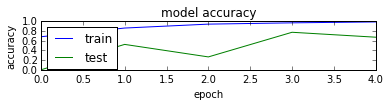

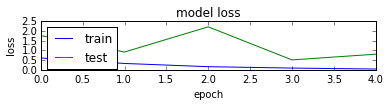

123 [ 0.99809605  0.00190397]
acc: 67.19%
79.17% (+/- 14.79%)


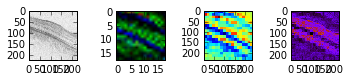

In [8]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==256 and test_index[0]<383:
        print "The OCT Volume 3"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_3.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 4
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.6018 - acc: 0.6888 - val_loss: 0.8433 - val_acc: 0.5469
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3118 - acc: 0.8679 - val_loss: 0.9142 - val_acc: 0.5938
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1515 - acc: 0.9413 - val_loss: 0.9307 - val_acc: 0.6562
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0707 - acc: 0.9740 - val_loss: 1.7723 - val_acc: 0.6016
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.9493197798728943)
('Test accuracy:', 0.625)
['acc', 'loss', 'val_acc', 'val_loss']


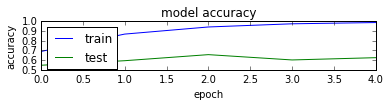

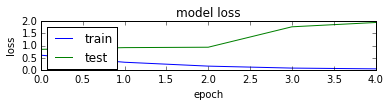

107 [  9.99937177e-01   6.28469352e-05]
acc: 62.50%
75.00% (+/- 14.70%)


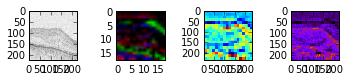

In [9]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==384 and test_index[0]<511:
        print "The OCT Volume 4"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_4.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 5
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5963 - acc: 0.6905 - val_loss: 1.5100 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3153 - acc: 0.8642 - val_loss: 0.6565 - val_acc: 0.6875
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1666 - acc: 0.9307 - val_loss: 0.9544 - val_acc: 0.5781
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0843 - acc: 0.9700 - val_loss: 0.6478 - val_acc: 0.7500
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.873475581407547)
('Test accuracy:', 0.5234375)
['acc', 'loss', 'val_acc', 'val_loss']


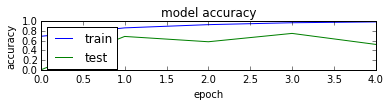

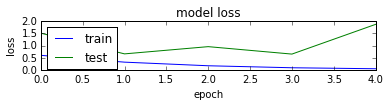

63 [ 0.40267247  0.59732747]
acc: 52.34%
70.47% (+/- 15.97%)


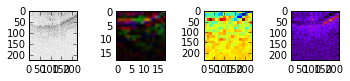

In [10]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==512 and test_index[0]<639:
        print "The OCT Volume 5"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_5.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 6
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6025 - acc: 0.6749 - val_loss: 0.2506 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3201 - acc: 0.8637 - val_loss: 0.0477 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1731 - acc: 0.9322 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0886 - acc: 0.9693 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.057913246564567089)
('Test accuracy:', 0.984375)
['acc', 'loss', 'val_acc', 'val_loss']


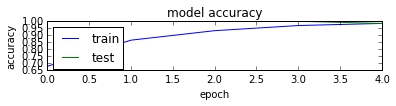

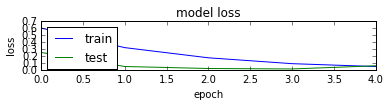

46 [ 0.9784171   0.02158288]
acc: 98.44%
75.13% (+/- 17.92%)


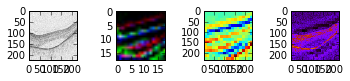

In [11]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==640 and test_index[0]<767:
        print "The OCT Volume 6"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_6.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 7
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 68s - loss: 0.5790 - acc: 0.6941 - val_loss: 1.8873 - val_acc: 0.4297
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.2792 - acc: 0.8846 - val_loss: 2.9251 - val_acc: 0.4609
Epoch 3/5
3968/3968 [==============================] - 69s - loss: 0.1388 - acc: 0.9476 - val_loss: 3.8667 - val_acc: 0.4844
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0670 - acc: 0.9788 - val_loss: 4.0477 - val_acc: 0.5234
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 6.4152073860168457)
('Test accuracy:', 0.4140625)
['acc', 'loss', 'val_acc', 'val_loss']


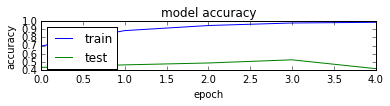

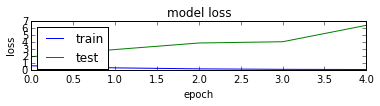

93 [  2.52334539e-05   9.99974728e-01]
acc: 41.41%
57.23% (+/- 28.61%)


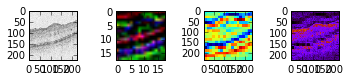

In [42]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==768 and test_index[0]<895:
        print "The OCT Volume 7"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_7.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 8
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5905 - acc: 0.6867 - val_loss: 1.5080 - val_acc: 0.0078
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3118 - acc: 0.8647 - val_loss: 0.8148 - val_acc: 0.4531
Epoch 3/5
3968/3968 [==============================] - 67s - loss: 0.1535 - acc: 0.9441 - val_loss: 0.7375 - val_acc: 0.6719
Epoch 4/5
3968/3968 [==============================] - 61s - loss: 0.0779 - acc: 0.9715 - val_loss: 1.5043 - val_acc: 0.5156
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 3.8253334164619446)
('Test accuracy:', 0.2734375)
['acc', 'loss', 'val_acc', 'val_loss']


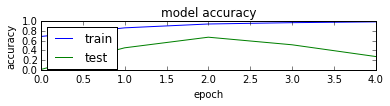

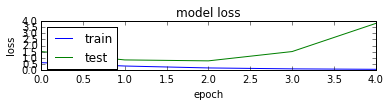

25 [ 0.99303269  0.00696733]
acc: 27.34%
65.33% (+/- 23.39%)


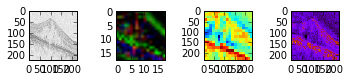

In [13]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==896 and test_index[0]<1023:
        print "The OCT Volume 8"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_8.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 9
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6119 - acc: 0.7054 - val_loss: 0.9509 - val_acc: 0.2422
Epoch 2/5
3968/3968 [==============================] - 67s - loss: 0.2829 - acc: 0.8755 - val_loss: 0.7009 - val_acc: 0.5156
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1365 - acc: 0.9506 - val_loss: 0.8798 - val_acc: 0.4766
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0694 - acc: 0.9745 - val_loss: 2.2472 - val_acc: 0.2969
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.83377866446971893)
('Test accuracy:', 0.6328125)
['acc', 'loss', 'val_acc', 'val_loss']


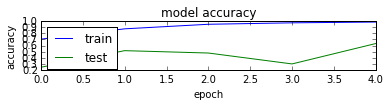

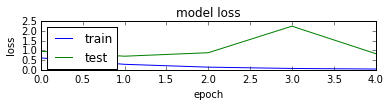

12 [ 0.93223321  0.06776684]
acc: 63.28%
81.64% (+/- 18.36%)


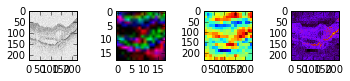

In [7]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1024 and test_index[0]<1151:
        print "The OCT Volume 9"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_9.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 10
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6097 - acc: 0.6716 - val_loss: 0.2982 - val_acc: 0.8750
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3179 - acc: 0.8682 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1716 - acc: 0.9322 - val_loss: 0.0411 - val_acc: 1.0000
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0808 - acc: 0.9710 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.063527230406180024)
('Test accuracy:', 0.9765625)
['acc', 'loss', 'val_acc', 'val_loss']


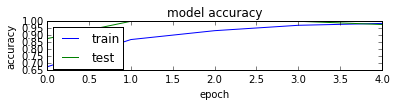

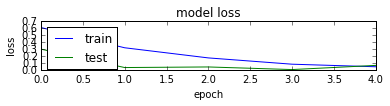

29 [  9.99866843e-01   1.33093403e-04]
acc: 97.66%
64.92% (+/- 25.98%)


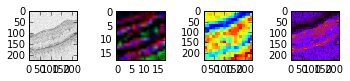

In [15]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1152 and test_index[0]<1279:
        print "The OCT Volume 10"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_10.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 11
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5866 - acc: 0.6903 - val_loss: 0.4032 - val_acc: 0.8906
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3253 - acc: 0.8579 - val_loss: 0.6466 - val_acc: 0.5938
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1672 - acc: 0.9309 - val_loss: 0.7221 - val_acc: 0.5859
Epoch 4/5
3968/3968 [==============================] - 69s - loss: 0.0874 - acc: 0.9672 - val_loss: 0.2107 - val_acc: 0.9453
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.3212941586971283)
('Test accuracy:', 0.5390625)
['acc', 'loss', 'val_acc', 'val_loss']


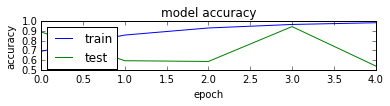

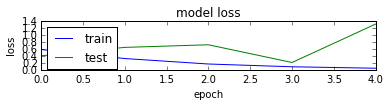

116 [ 0.83932185  0.16067815]
acc: 53.91%
63.92% (+/- 24.97%)


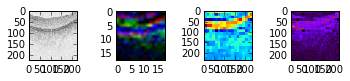

In [16]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1280 and test_index[0]<1407:
        print "The OCT Volume 11"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_11.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 12
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5922 - acc: 0.6787 - val_loss: 0.4106 - val_acc: 0.9922
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3226 - acc: 0.8669 - val_loss: 0.2111 - val_acc: 0.9766
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1612 - acc: 0.9420 - val_loss: 0.1201 - val_acc: 0.9922
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0816 - acc: 0.9708 - val_loss: 0.0666 - val_acc: 0.9922
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.026686084689572453)
('Test accuracy:', 1.0)
['acc', 'loss', 'val_acc', 'val_loss']


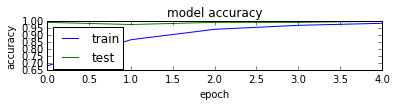

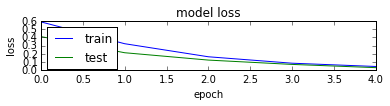

88 [ 0.17123939  0.82876062]
acc: 100.00%
66.93% (+/- 25.90%)


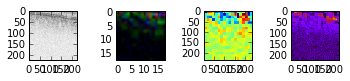

In [17]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1408 and test_index[0]<1535:
        print "The OCT Volume 12"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_12.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 13
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5941 - acc: 0.6842 - val_loss: 0.2833 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3189 - acc: 0.8609 - val_loss: 0.0899 - val_acc: 1.0000
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1652 - acc: 0.9350 - val_loss: 0.2422 - val_acc: 0.8438
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0809 - acc: 0.9680 - val_loss: 0.1023 - val_acc: 0.9609
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.16212725639343262)
('Test accuracy:', 0.9375)
['acc', 'loss', 'val_acc', 'val_loss']


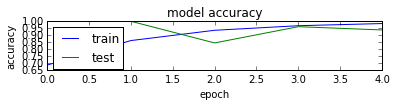

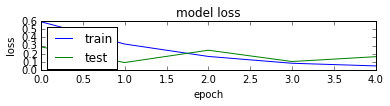

66 [ 0.40821075  0.59178925]
acc: 93.75%
68.99% (+/- 25.89%)


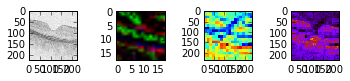

In [18]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1536 and test_index[0]<1663:
        print "The OCT Volume 13"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_13.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 14
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6119 - acc: 0.6847 - val_loss: 1.3392 - val_acc: 0.4297
Epoch 2/5
3968/3968 [==============================] - 61s - loss: 0.3195 - acc: 0.8634 - val_loss: 4.1322 - val_acc: 0.0312
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1465 - acc: 0.9428 - val_loss: 9.2949 - val_acc: 0.0000e+00
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0693 - acc: 0.9753 - val_loss: 6.9401 - val_acc: 0.0625
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 10.703272342681885)
('Test accuracy:', 0.0)
['acc', 'loss', 'val_acc', 'val_loss']


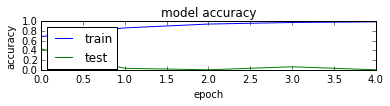

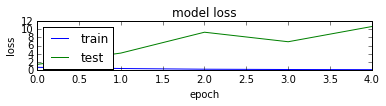

127 [  1.00000000e+00   1.32469937e-08]
acc: 0.00%
0.00% (+/- 0.00%)


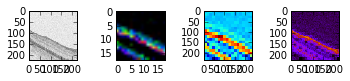

In [7]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1664 and test_index[0]<1791:
        print "The OCT Volume 14"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_14.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 15
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5930 - acc: 0.6890 - val_loss: 1.5756 - val_acc: 0.1562
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3317 - acc: 0.8594 - val_loss: 0.8223 - val_acc: 0.5859
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1683 - acc: 0.9367 - val_loss: 1.1914 - val_acc: 0.5781
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0844 - acc: 0.9703 - val_loss: 2.1153 - val_acc: 0.4141
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.6828828454017639)
('Test accuracy:', 0.5703125)
['acc', 'loss', 'val_acc', 'val_loss']


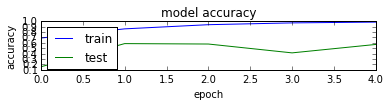

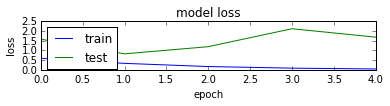

79 [ 0.99236006  0.00764001]
acc: 57.03%
63.75% (+/- 29.31%)


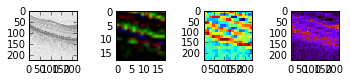

In [20]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1792 and test_index[0]<1919:
        print "The OCT Volume 15"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_15.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 16
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5969 - acc: 0.6855 - val_loss: 0.4117 - val_acc: 0.9219
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3116 - acc: 0.8662 - val_loss: 0.7431 - val_acc: 0.7109
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1633 - acc: 0.9372 - val_loss: 0.1877 - val_acc: 0.9062
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0804 - acc: 0.9710 - val_loss: 0.1584 - val_acc: 0.9375
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.66594874113798141)
('Test accuracy:', 0.7578125)
['acc', 'loss', 'val_acc', 'val_loss']


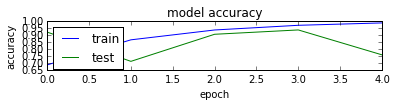

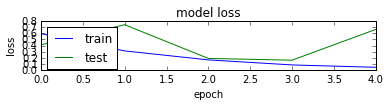

102 [ 0.27147096  0.72852904]
acc: 75.78%
64.50% (+/- 28.53%)


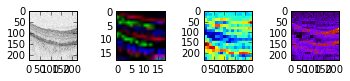

In [21]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==1920 and test_index[0]<2047:
        print "The OCT Volume 16"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_16.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 17
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 99s - loss: 0.6018 - acc: 0.6885 - val_loss: 1.9133 - val_acc: 0.0000e+00
Epoch 2/5
3968/3968 [==============================] - 92s - loss: 0.2855 - acc: 0.8755 - val_loss: 4.6499 - val_acc: 0.0000e+00
Epoch 3/5
3968/3968 [==============================] - 98s - loss: 0.1561 - acc: 0.9398 - val_loss: 2.3578 - val_acc: 0.0078
Epoch 4/5
3968/3968 [==============================] - 92s - loss: 0.0752 - acc: 0.9715 - val_loss: 5.9603 - val_acc: 0.0000e+00
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 5.5430080890655518)
('Test accuracy:', 0.0)
['acc', 'loss', 'val_acc', 'val_loss']


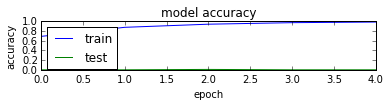

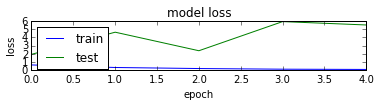

80 [ 0.99900085  0.00099914]
acc: 0.00%
22.58% (+/- 8.84%)


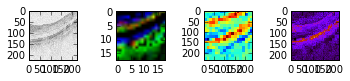

In [42]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2048 and test_index[0]<2175:
        print "The OCT Volume 17"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_17.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 18
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5961 - acc: 0.6963 - val_loss: 0.2060 - val_acc: 1.0000
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3153 - acc: 0.8672 - val_loss: 0.3296 - val_acc: 0.8359
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1625 - acc: 0.9355 - val_loss: 1.1999 - val_acc: 0.4688
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0823 - acc: 0.9708 - val_loss: 0.4641 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.0194913893938065)
('Test accuracy:', 0.5234375)
['acc', 'loss', 'val_acc', 'val_loss']


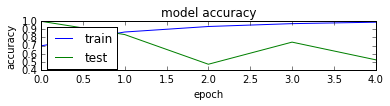

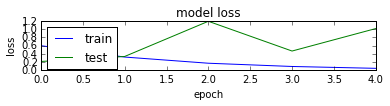

101 [  8.62388970e-06   9.99991417e-01]
acc: 52.34%
60.24% (+/- 30.74%)


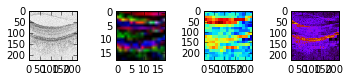

In [23]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2176 and test_index[0]<2303:
        print "The OCT Volume 18"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_18.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 19
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 67s - loss: 0.6200 - acc: 0.6749 - val_loss: 0.7151 - val_acc: 0.5703
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3256 - acc: 0.8604 - val_loss: 2.2867 - val_acc: 0.2656
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1669 - acc: 0.9395 - val_loss: 2.9527 - val_acc: 0.2344
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0927 - acc: 0.9667 - val_loss: 2.9408 - val_acc: 0.2969
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 6.7094904184341431)
('Test accuracy:', 0.140625)
['acc', 'loss', 'val_acc', 'val_loss']


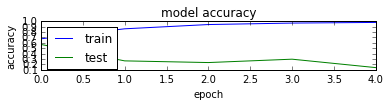

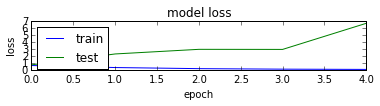

97 [  9.99947309e-01   5.26716140e-05]
acc: 14.06%
20.31% (+/- 5.85%)


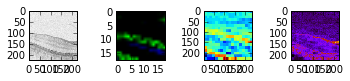

In [13]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2304 and test_index[0]<2431:
        print "The OCT Volume 19"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_19.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 20
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5971 - acc: 0.6724 - val_loss: 0.3699 - val_acc: 0.8750
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3220 - acc: 0.8619 - val_loss: 0.3069 - val_acc: 0.8906
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1565 - acc: 0.9383 - val_loss: 1.0843 - val_acc: 0.4609
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0732 - acc: 0.9751 - val_loss: 0.7366 - val_acc: 0.6250
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.6206632256507874)
('Test accuracy:', 0.3828125)
['acc', 'loss', 'val_acc', 'val_loss']


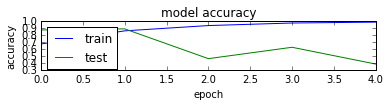

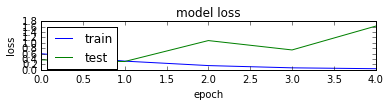

41 [ 0.71623993  0.2837601 ]
acc: 38.28%
57.19% (+/- 30.69%)


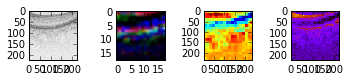

In [25]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2432 and test_index[0]<2559:
        print "The OCT Volume 20"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_20.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 21
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5811 - acc: 0.6935 - val_loss: 1.0913 - val_acc: 0.1953
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2958 - acc: 0.8742 - val_loss: 2.8601 - val_acc: 0.0625
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1510 - acc: 0.9420 - val_loss: 0.6406 - val_acc: 0.7031
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0753 - acc: 0.9751 - val_loss: 1.3144 - val_acc: 0.4297
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 2.9138810634613037)
('Test accuracy:', 0.1328125)
['acc', 'loss', 'val_acc', 'val_loss']


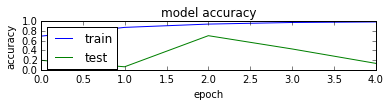

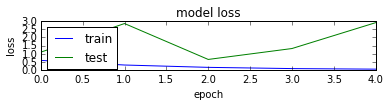

26 [ 0.9839384   0.01606166]
acc: 13.28%
55.10% (+/- 31.37%)


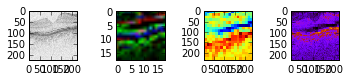

In [26]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2560 and test_index[0]<2687:
        print "The OCT Volume 21"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_21.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 22
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6002 - acc: 0.6870 - val_loss: 0.5874 - val_acc: 0.7500
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3183 - acc: 0.8611 - val_loss: 0.7136 - val_acc: 0.5859
Epoch 3/5
3968/3968 [==============================] - 69s - loss: 0.1649 - acc: 0.9365 - val_loss: 0.4118 - val_acc: 0.8359
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0850 - acc: 0.9718 - val_loss: 0.2733 - val_acc: 0.8828
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.49906260520219803)
('Test accuracy:', 0.7578125)
['acc', 'loss', 'val_acc', 'val_loss']


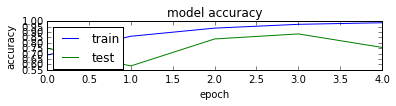

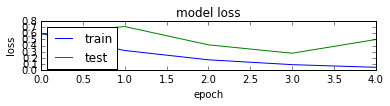

28 [ 0.00222415  0.99777585]
acc: 75.78%
56.04% (+/- 30.95%)


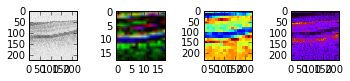

In [27]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2688 and test_index[0]<2815:
        print "The OCT Volume 22"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_22.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 23
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 68s - loss: 0.6560 - acc: 0.7074 - val_loss: 0.7849 - val_acc: 0.6641
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2497 - acc: 0.8939 - val_loss: 2.9744 - val_acc: 0.1328
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1202 - acc: 0.9534 - val_loss: 1.4191 - val_acc: 0.5703
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0588 - acc: 0.9791 - val_loss: 6.4221 - val_acc: 0.0234
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 5.4632499217987061)
('Test accuracy:', 0.09375)
['acc', 'loss', 'val_acc', 'val_loss']


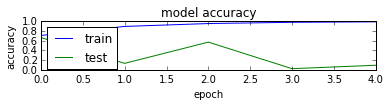

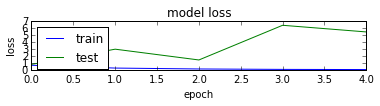

75 [ 0.0888221   0.91117787]
acc: 9.38%
14.06% (+/- 4.69%)


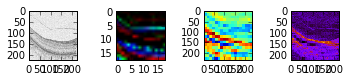

In [8]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2816 and test_index[0]<2943:
        print "The OCT Volume 23"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_23.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 24
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5855 - acc: 0.6878 - val_loss: 1.0306 - val_acc: 0.3203
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3137 - acc: 0.8637 - val_loss: 0.2140 - val_acc: 0.8984
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1576 - acc: 0.9403 - val_loss: 0.6553 - val_acc: 0.7422
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0823 - acc: 0.9710 - val_loss: 0.7145 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.79097457230091095)
('Test accuracy:', 0.7890625)
['acc', 'loss', 'val_acc', 'val_loss']


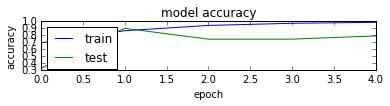

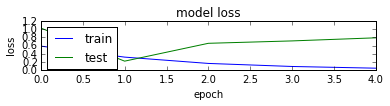

19 [ 0.98211694  0.01788314]
acc: 78.91%
55.24% (+/- 31.19%)


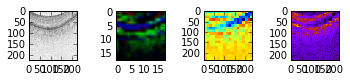

In [31]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==2944 and test_index[0]<3071:
        print "The OCT Volume 24"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_24.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 25
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 61s - loss: 0.5885 - acc: 0.6842 - val_loss: 1.3544 - val_acc: 0.0859
Epoch 2/5
3968/3968 [==============================] - 69s - loss: 0.3132 - acc: 0.8657 - val_loss: 1.5667 - val_acc: 0.2188
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1640 - acc: 0.9388 - val_loss: 1.7266 - val_acc: 0.3203
Epoch 4/5
3968/3968 [==============================] - 72s - loss: 0.0834 - acc: 0.9693 - val_loss: 0.9363 - val_acc: 0.5312
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 1.9117372632026672)
('Test accuracy:', 0.4296875)
['acc', 'loss', 'val_acc', 'val_loss']


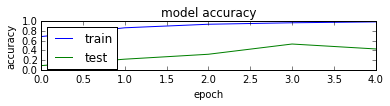

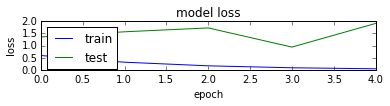

115 [ 0.145       0.85500002]
acc: 42.97%
54.75% (+/- 30.66%)


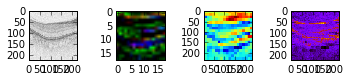

In [32]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3072 and test_index[0]<3199:
        print "The OCT Volume 25"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_25.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 26
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 61s - loss: 0.5817 - acc: 0.7026 - val_loss: 1.4867 - val_acc: 0.1953
Epoch 2/5
3968/3968 [==============================] - 68s - loss: 0.3068 - acc: 0.8725 - val_loss: 1.0319 - val_acc: 0.6016
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1581 - acc: 0.9418 - val_loss: 2.1435 - val_acc: 0.4922
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0845 - acc: 0.9693 - val_loss: 2.9311 - val_acc: 0.4844
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 2.7009645700454712)
('Test accuracy:', 0.546875)
['acc', 'loss', 'val_acc', 'val_loss']


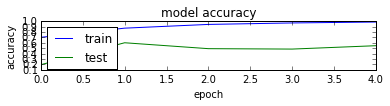

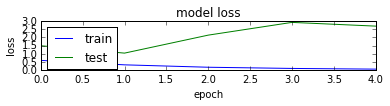

56 [  9.99974012e-01   2.60222278e-05]
acc: 54.69%
54.75% (+/- 30.06%)


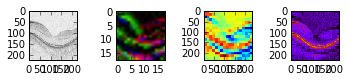

In [33]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3200 and test_index[0]<3327:
        print "The OCT Volume 26"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_26.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 27
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 100s - loss: 0.5984 - acc: 0.6973 - val_loss: 0.9428 - val_acc: 0.5391
Epoch 2/5
3968/3968 [==============================] - 92s - loss: 0.2952 - acc: 0.8765 - val_loss: 1.6243 - val_acc: 0.4531
Epoch 3/5
3968/3968 [==============================] - 92s - loss: 0.1593 - acc: 0.9398 - val_loss: 3.4027 - val_acc: 0.3359
Epoch 4/5
3968/3968 [==============================] - 90s - loss: 0.0937 - acc: 0.9655 - val_loss: 4.1348 - val_acc: 0.3438
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 3.4982349872589111)
('Test accuracy:', 0.359375)
['acc', 'loss', 'val_acc', 'val_loss']


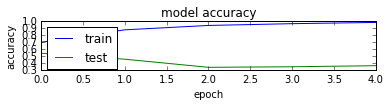

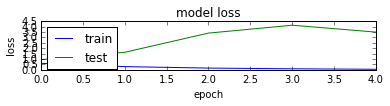

86 [ 0.00142362  0.9985764 ]
acc: 35.94%
22.95% (+/- 8.87%)


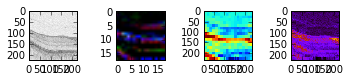

In [44]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3328 and test_index[0]<3455:
        print "The OCT Volume 27"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_27.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 28
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.6084 - acc: 0.6809 - val_loss: 0.7308 - val_acc: 0.6406
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3133 - acc: 0.8702 - val_loss: 1.5480 - val_acc: 0.3672
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1626 - acc: 0.9360 - val_loss: 0.8016 - val_acc: 0.7422
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0810 - acc: 0.9725 - val_loss: 1.1066 - val_acc: 0.7422
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.91423062980175018)
('Test accuracy:', 0.796875)
['acc', 'loss', 'val_acc', 'val_loss']


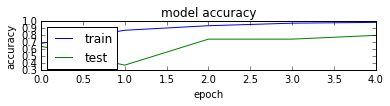

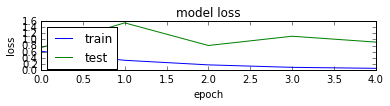

29 [ 0.99898142  0.00101855]
acc: 79.69%
55.11% (+/- 29.48%)


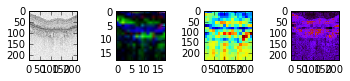

In [35]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3456 and test_index[0]<3583:
        print "The OCT Volume 28"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_28.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 29
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5804 - acc: 0.6920 - val_loss: 0.5053 - val_acc: 0.8672
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.3103 - acc: 0.8727 - val_loss: 0.6404 - val_acc: 0.6797
Epoch 3/5
3968/3968 [==============================] - 68s - loss: 0.1646 - acc: 0.9388 - val_loss: 0.1615 - val_acc: 0.9609
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0876 - acc: 0.9685 - val_loss: 0.1999 - val_acc: 0.9375
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.083306676708161831)
('Test accuracy:', 0.9609375)
['acc', 'loss', 'val_acc', 'val_loss']


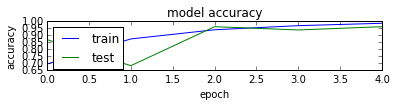

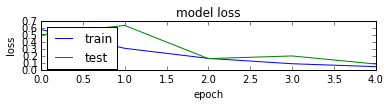

78 [ 0.96613353  0.03386643]
acc: 96.09%
56.52% (+/- 29.92%)


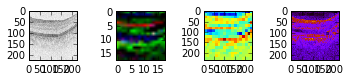

In [36]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3584 and test_index[0]<3711:
        print "The OCT Volume 29"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_29.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 30
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5906 - acc: 0.6968 - val_loss: 0.4915 - val_acc: 0.7969
Epoch 2/5
3968/3968 [==============================] - 62s - loss: 0.2992 - acc: 0.8720 - val_loss: 0.5120 - val_acc: 0.7656
Epoch 3/5
3968/3968 [==============================] - 62s - loss: 0.1592 - acc: 0.9425 - val_loss: 1.5167 - val_acc: 0.4219
Epoch 4/5
3968/3968 [==============================] - 62s - loss: 0.0751 - acc: 0.9756 - val_loss: 2.8984 - val_acc: 0.2500
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.42064186185598373)
('Test accuracy:', 0.8984375)
['acc', 'loss', 'val_acc', 'val_loss']


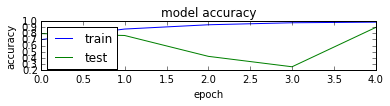

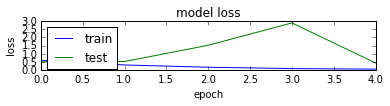

96 [ 0.03716024  0.96283984]
acc: 89.84%
57.63% (+/- 30.02%)


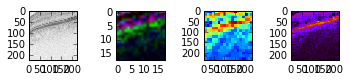

In [37]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3712 and test_index[0]<3839:
        print "The OCT Volume 30"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_30.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 31
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 62s - loss: 0.5899 - acc: 0.6862 - val_loss: 0.7578 - val_acc: 0.5000
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3213 - acc: 0.8591 - val_loss: 0.3733 - val_acc: 0.8984
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1683 - acc: 0.9367 - val_loss: 0.1981 - val_acc: 0.9609
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0851 - acc: 0.9725 - val_loss: 0.1015 - val_acc: 0.9688
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.67731521278619766)
('Test accuracy:', 0.6484375)
['acc', 'loss', 'val_acc', 'val_loss']


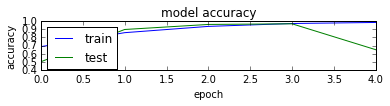

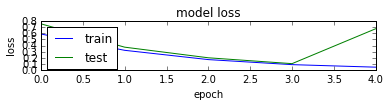

109 [  5.90410957e-04   9.99409556e-01]
acc: 64.84%
57.86% (+/- 29.56%)


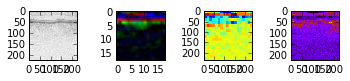

In [38]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3840 and test_index[0]<3967:
        print "The OCT Volume 31"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_31.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

The OCT Volume 32
(3968, 3, 224, 224) (128, 3, 224, 224) (3968, 2) (128, 2)
Train on 3968 samples, validate on 128 samples
Epoch 1/5
3968/3968 [==============================] - 63s - loss: 0.5881 - acc: 0.6893 - val_loss: 1.4425 - val_acc: 0.1172
Epoch 2/5
3968/3968 [==============================] - 70s - loss: 0.3102 - acc: 0.8657 - val_loss: 1.3742 - val_acc: 0.2188
Epoch 3/5
3968/3968 [==============================] - 70s - loss: 0.1676 - acc: 0.9312 - val_loss: 1.9620 - val_acc: 0.3281
Epoch 4/5
3968/3968 [==============================] - 68s - loss: 0.0848 - acc: 0.9693 - val_loss: 0.0207 - val_acc: 1.0000
Epoch 5/5
128/128 [==============================] - 0s     
('Test score:', 0.50010289996862411)
('Test accuracy:', 0.8515625)
['acc', 'loss', 'val_acc', 'val_loss']


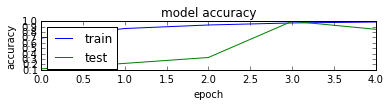

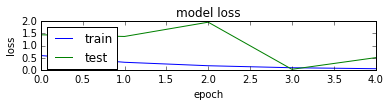

21 [ 0.00826377  0.99173623]
acc: 85.16%
58.72% (+/- 29.48%)


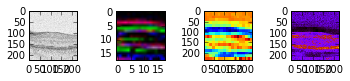

In [39]:
cv = cross_validation.KFold(4096, n_folds=32,shuffle=False,random_state=None)
for train_index, test_index in cv:
    if test_index[0]==3968:
        print "The OCT Volume 32"
        pru=[]
        aba=[]
        for i in range(0,3968):
            at=all_input_3D[train_index[i]]
            pru.append(at)
        pru2=[]
        aba2=[]
        for j in range(0,128):
            at2=all_input_3D[test_index[j]]
            pru2.append(at2)
        X_tr, X_tes = np.asarray(pru), np.asarray(pru2)
        #y_tr, y_tes = np.asarray(aba), np.asarray(aba2)
        y_tr, y_tes = aba1[train_index[0:3968]],aba1[test_index[0:128]]
        print X_tr.shape, X_tes.shape, y_tr.shape, y_tes.shape
        # create model
        #model1 = Model(input=input, output=[dense3])
        #for layer in model1.layers:
        #    layer.trainable = True
        #model1 = Model(input=input, output=[dense3]
        model1.load_weights('model_OCTNET.h5')
        # Fit the model
        #model.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=1)
        checkpointer = ModelCheckpoint(filepath="/home/ojperdomoc/OCT_HES-SO/OCT_NET_32.hdf5", monitor='val_acc', verbose=1, save_best_only=True)
        history = model1.fit([X_tr], [y_tr], batch_size=batch_size, nb_epoch=nb_epochs,verbose=1,validation_data=(X_tes, y_tes),callbacks=[checkpointer])
        # evaluate the model
        bb1=model1.predict([X_tes])
        scores = model1.evaluate([X_tes], [y_tes], verbose=1)
        print('Test score:', scores[0])
        print('Test accuracy:', scores[1])
        #plt.imshow(Y_hat_mask[0].transpose(1,2,0).squeeze())
        #print('The number of OCT classified correctly are:', np.sum(bb1==label_0[test_index[0:128]]))
        #print('The test index',[test_index[0:128]][0],[test_index[0:128]][127])
        # list all data in history
        print(history.history.keys())
        ax1 = plt.subplot2grid((4,4), (0,0), colspan=4)
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        ax2 = plt.subplot2grid((4,4), (1,0), colspan=4)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        Y_hat = conv10.eval({input: X_tes.astype('float32')})
        input2 = Input(shape=(256,18,18))
        final_conv1 = Convolution2D(1, 1, 1, activation='sigmoid')(input2)
        upsample13 = UpSampling2D(size=(13, 13), dim_ordering='th')(final_conv1)
        model_mask = Model(input=input2, output=[upsample13])
        Y_hat_mask = upsample13.eval({input2: Y_hat})
        slice_idx = random.randint(0, 127)
        #plt.figure()
        #plt.subplot(1,4,1)
        ax3 = plt.subplot2grid((4,4), (2, 0))
        plt.imshow((X_tes[slice_idx]).transpose(1,2,0))
        plt.savefig('0_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,2)
        ax4 = plt.subplot2grid((4,4), (2, 1))
        plt.imshow((Y_hat[slice_idx][0:3]).transpose(1,2,0))
        plt.savefig('1_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,3)
        ax5 = plt.subplot2grid((4,4), (2, 2))
        plt.imshow(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())
        plt.savefig('2_'+str(test_index[0])+'.svg')
        #plt.subplot(1,4,4)
        ax6 = plt.subplot2grid((4,4), (2, 3))
        mask_rsz=(Y_hat_mask[slice_idx].transpose(1,2,0).squeeze())#
        #data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        mask_rsz1=imresize(mask_rsz,(224,224),'bicubic').astype('float32')
        over_all = np.zeros((224,224))
        over_all = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,0])*(mask_rsz1)
        #over_all[:,:,1] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,1])*(mask_rsz1)
        #over_all[:,:,2] = ((X_tes[slice_idx]).transpose(1,2,0)[:,:,2])*(mask_rsz1)
        plt.imshow(over_all,cmap='gnuplot')
        plt.savefig('3_'+str(test_index[0])+'.svg')
        print slice_idx, bb1[slice_idx]
        print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        bb.append(bb1)
    else:
        test_index[0]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))